# importing the libraries

In [ ]:
import spacy

try:
  nlp = spacy.load("en_core_web_lg")
except:
  !python3 -m spacy download en_core_web_lg
  nlp = spacy.load("en_core_web_lg")


/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import unicodedata
from wordcloud import WordCloud as wc
from matplotlib import pyplot as plt
from textblob import TextBlob

TextBlob can be used for correcting supposedly incorrect spellings and tokenization.
Spacy tokenizes keeping the incorrect spellings as it is, however TextBlob corrects the spellings as well during tokenization

Check for the project requirement before deciding on whether to use either of them

# Importing the Dataset

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/twitt30k.csv")
df

,twitts,sentiment
0,@robbiebronniman Sounds like a great night.,1
1,Damn the person who stolde my wallet !!!!! Ma...,1
2,Greetings from the piano bench (photo) http:/...,1
3,@drewryanscott i love it!! i love you!! haha f...,1
4,"@kissthestars Pretty pretty pretty please, pak...",0
...,...,...
29995,@Calumfan1 is it in any way related to photosh...,0
29996,@Swiz_NZ really? wow thats crap,0
29997,"At the 2010 lexus HS250h press event. Again, ...",0
29998,@karmicunderpath ooooh now there's a nice thou...,1


# Preprocessing

## Token Counts

In [ ]:
df["word_count"] = df.twitts.map(lambda x: len(x.split()))

In [ ]:
df["char_count"] = df.twitts.map(lambda x: len("".join(c for c in x.split())))

In [ ]:
df["avg_word_length"] = df.char_count/df.word_count

Uppercase words may mean someone is angry. So, uppercase words can be a good indicator of strong emotions.

However, an uppercase word may actually be an internet lingo. this may produce error. So, create a dictionary of most commonly used lingos

In [ ]:
exclusions = ["LOL", "LMAO", "ROFL", "IG", "STFU", "RSVP", "ASAP", "FYI", "PAW",
              "AFK", "PITR", "JK", "ILU", "ILY", "WTF", "BAE", "BFF", "AFAIK",
              "AFAIR", "I", "VA", "WA", 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO',
              'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS',
              'KY', 'LA', 'MA', 'MD', 'ME','MI', 'MN', 'MO', 'MS', 'MT', 'NC',
              'ND', 'NE', 'NH', 'NJ', 'NM','NV', 'NY', 'OH', 'OK', 'OR', 'PA',
              'RI', 'SC', 'SD', 'TN', 'TX','UT', 'VA', 'VT', 'WA', 'WI', 'WV',
              'WY', "WB", "BC", "AD", "LG", "MS", "GM", "SMS", "ABC", "NBC",
              "CBS", "PBS", "TBS", "KKR", "CSK", "RCB", "LG WM2016C", "IE8",
              "IE9", "IE10", "IE7", "BBC", "AM", "PM", "DD", "RAM", "ROM", "DC",
              "CW", "IDK", "ATL", "NKOTB", "NWA", "A"]
df["hi_emotion"] = df.twitts.map(lambda x: len([word for word in x.split() if word.isupper() and word not in exclusions]))

Counting the digits in the text.

In [ ]:
df["num_count"] = df.twitts.map(lambda x: len([token for token in x.split() if token.isdigit()]))

## Cleaning the text

##### Convert to lowercase

In [ ]:
#df["twitts"] = df.twitts.str.lower()

##### Expanding contractions

In [ ]:
contractions = {
  "ain't": "am not", "aren't": "are not", "can't": "cannot", "you're": "you are",
  "can't've": "cannot have", "'cause": "because", "could've": "could have",
  "couldn't": "could not", "couldn't've": "could not have", "why's": "why is",
  "didn't": "did not", "doesn't": "does not", "don't": "do not",
  "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not",
  "haven't": "have not", "he'd": "he would", "he'd've": "he would have",
  "he'll": "he will", "he'll've": "he will have", "he's": "he is",
  "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
  "how's": "how is", "i'd": "i would", "i'd've": "i would have",
  "i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have",
  "isn't": "is not", "it'd": "it had", "it'd've": "it would have",
  "it'll": "it will", "it'll've": "it will have", "it's": "it is",
  "let's": "let us", "ma'am": "madam", "mayn't": "may not", "when's": "when is",
  "might've": "might have", "mightn't": "might not", "we'll": "we will",
  "mightn't've": "might not have", "must've": "must have", "what's": "what is",
  "mustn't've": "must not have", "needn't": "need not", "we've": "we have",
  "needn't've":"need not have","o'clock":"of the clock", "oughtn't":"ought not",
  "oughtn't've": "ought not have","shan't": "shall not", "sha'n't": "shall not",
  "shan't've": "shall not have", "she'd": "she would", "weren't": "were not",
  "she'd've": "she would have","she'll": "she will","she'll've":"she will have",
  "she's": "she is", "should've": "should have", "shouldn't": "should not",
  "shouldn't've": "should not have", "so've": "so have", "so's": "so is",
  "that'd": "that would", "that'd've": "that would have", "that's": "that is",
  "there'd": "there had","there'd've": "there would have","there's": "there is",
  "they'd": "they would", "they'd've": "they would have","they'll": "they will",
  "they'll've": "they will have", "they're": "they are", "they've": "they have",
  "to've": "to have", "wasn't": "was not", "we'd": "we had", "we're": "we are",
  "we'd've": "we would have", "mustn't": "must not", "we'll've": "we will have",
  "what'll": "what will", "what'll've": "what will have", "what're": "what are",
  "what've": "what have", "when've": "when have", "where'd": "where did",
  "where's": "where is", "where've": "where have", "who'll": "who will",
  "who'll've": "who will have", "who's": "who is", "won't": "will not",
  "who've": "who have", "why've": "why have", "will've": "will have",
  "won't've": "will not have", "would've": "would have", "y'all": "you all",
  "wouldn't": "would not", "wouldn't've": "would not have",
  "y'alls": "you alls", "y'all'd": "you all would", "you'd": "you had",
  "y'all'd've": "you all would have", "y'all're": "you all are",
  "y'all've": "you all have", "you'd've": "you would have",
  "you'll": "you will", "you'll've": "you will have",
  "you've": "you have"
}

In [ ]:
df["twitts"] = df.twitts.map(lambda x: " ".join([word if word not in contractions.keys() else contractions[word] for word in x.split()]))

### Removing

##### counting and removing hashtags

In [ ]:
df["hashtags"] = df.twitts.map(lambda x: len([word for word in x.split() if word.startswith("#") and len(word) > 1]))
df["twitts"] = df.twitts.map(lambda x: " ".join(["" if word.startswith("#") and len(word) > 1 else word for word in x.split()]))

##### counting and removing mentions

In [ ]:
df["mentions"] = df.twitts.map(lambda x: len([word for word in x.split() if word.startswith("@") and len(word) > 1]))
df["twitts"] = df.twitts.map(lambda x: " ".join(["" if word.startswith("@") and len(word) > 1 else word for word in x.split()]))

##### Counting and removing email id

In [ ]:
df["email_id_count"] = df.twitts.map(lambda x: len(re.findall(r'([a-zA-Z0-9+_.-]+@[a-zA-Z0-9+.-]+\.[a-zA-Z0-9+.-]+\b)', x)))
df["twitts"] = df.twitts.map(lambda x: re.sub(r'([a-zA-Z0-9+_.-]+@[a-zA-Z0-9+.-]+\.[a-zA-Z0-9+.-]+\b)', "", x))

##### Counting and removing the URLs.

In [ ]:
df["link_count"] = df.twitts.map(lambda x: len(re.findall(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', x)))
df["twitts"] = df.twitts.map(lambda x: re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', "", x))

##### Remove retweet sign RT

In [ ]:
df["twitts"] = df["twitts"].str.replace("RT ", "")

##### Remove special characters

numbers may be separated by commas. this can be tackled by first removing the commas from those numbers, then removing the commas from the whole doc.

In [ ]:
# for comma separated numbers and time
df["twitts"] = df.twitts.map(lambda x: re.sub(r"(\d*)([,:hmys])(\d+)", r'\1\3', x))

#for decimal digits
df["twitts"] = df.twitts.map(lambda x: re.sub(r"(\d*)[.](\d+)", r'\1_\2',x))

df["twitts"] = df.twitts.map(lambda x:re.sub(r'(\d) ([hmys]) (\d+)', r'\1\3 \2', x))

In [ ]:
df["twitts"] = df.twitts.map(lambda x: re.sub(r'[^\w]', " ", x))

##### remove multiple spaces

In [ ]:
df["twitts"] = df.twitts.map(lambda x: " ".join(x.split()))

##### Removing html tags

while it may not be the case here, sometimes there might be html tags remaining in the data, due to bad web scraping. use beautifulsoup4

In [ ]:
df["twitts"] = df.twitts.map(lambda x: BeautifulSoup(x, "lxml").get_text().strip())

##### Removing accented characters

In [ ]:
df["twitts"] = df.twitts.map(lambda x: unicodedata.normalize("NFKC", x.lstrip()).encode("ascii", "ignore").decode("utf-8"))

##### Remove stop words

In [ ]:
df["twitts"] = df.twitts.map(lambda x: " ".join([word for word in str(x).split() if word not in nlp.Defaults.stop_words]))

##### Lematization

we do not want to lose the context or sense of time in this case.
so it is better to keep 'was', 'is', etc. and pronouns as it is

In [ ]:
df["twitts"] = df.twitts.map(lambda x: " ".join([token.text if token.lemma_ == "-PRON-" or token.lemma_ == "be" else token.lemma_ for token in nlp(x)]))

##### separating alphanumeric words

In [ ]:
df["twitts"] = df.twitts.map(lambda x: re.sub(r'(\d)([a-zA-z])', r'\1 \2', x))
df["twitts"] = df.twitts.map(lambda x: re.sub(r'([a-zA-Z])(\d)', r'\1 \2', x))

##### remove a letter repeated more than three times

In [ ]:
df["twitts"] = df.twitts.map(lambda x: re.sub(r"([a-zA-Z0-9])\1{2,}", r"\1", x))

### Spelling Correction

In [ ]:
# df["twitts"] = df.twitts.map(lambda x: str(TextBlob(x).correct()))

## EDA

In [ ]:
text= " ".join(df.twitts)

In [ ]:
freq = pd.Series(text.split()).value_counts()

### Word Cloud Visualisation

In [ ]:
cloud = wc(width=800, height=400).generate_from_frequencies(dict(freq))

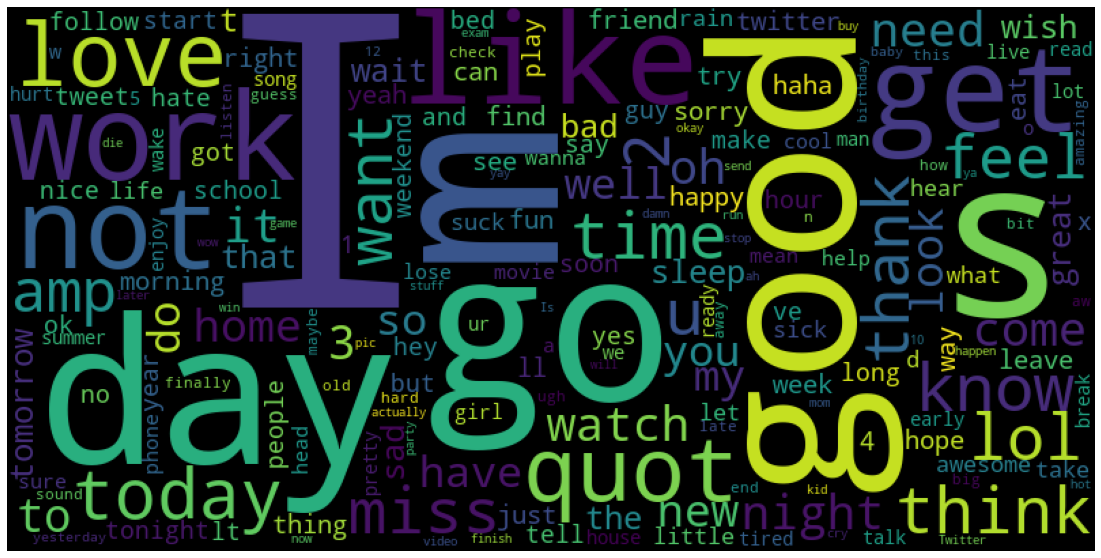

In [ ]:
fig, ax = plt.subplots(figsize=(45, 10))
ax.imshow(cloud)
plt.axis("off")
plt.show()

In [ ]:
df["sentiment"].value_counts()

1    15000
0    15000
Name: sentiment, dtype: int64

## sentiment vs word count

,word_count
sentiment,
0,13.528267
1,12.706933


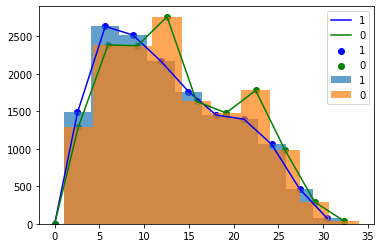

In [ ]:
plt.hist(df.loc[df.sentiment==1, "word_count"], alpha=0.7)
plt.hist(df.loc[df.sentiment==0, "word_count"], alpha=0.7)

y, bin_edge = np.histogram(df.loc[df.sentiment==1, "word_count"])
y = np.append(0, y)
bin_centre = np.append(0, (bin_edge[1: ] + bin_edge[: -1])/2)
plt.plot(bin_centre, y, c="blue")
plt.scatter(bin_centre, y, c="blue")

y, bin_edge = np.histogram(df.loc[df.sentiment==0, "word_count"])
y = np.append(0, y)
bin_centre = np.append(0, (bin_edge[1: ] + bin_edge[: -1])/2)
plt.plot(bin_centre, y, c="green")
plt.scatter(bin_centre, y, c="green")

plt.legend([1, 0, 1, 0, 1, 0])

df[["sentiment", "word_count"]].groupby("sentiment").mean()

word count does not seem to be of much significance here.

## sentiment vs char_count

,char_count
sentiment,
0,60.167867
1,60.628867


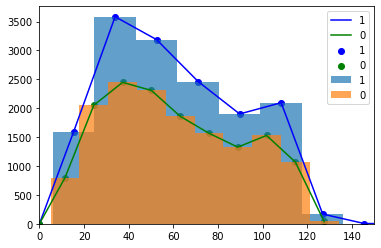

In [ ]:
plt.hist(df.loc[df.sentiment==1, "char_count"], alpha=0.7)
plt.hist(df.loc[df.sentiment==0, "char_count"], alpha=0.7)

y, bin_edge = np.histogram(df.loc[df.sentiment==1, "char_count"])
y = np.append(0, y)
bin_centre = np.append(0, (bin_edge[1: ] + bin_edge[: -1])/2)
plt.plot(bin_centre, y, c="blue")
plt.scatter(bin_centre, y, c="blue")

y, bin_edge = np.histogram(df.loc[df.sentiment==0, "char_count"])
y = np.append(0, y)
bin_centre = np.append(0, (bin_edge[1: ] + bin_edge[: -1])/2)
plt.plot(bin_centre, y, c="green")
plt.scatter(bin_centre, y, c="green")

plt.xlim(0, 150)
plt.legend([1, 0, 1, 0, 1, 0])

df[["sentiment", "char_count"]].groupby("sentiment").mean()

may be significant

## sentiment vs avg_word_length

,avg_word_length
sentiment,
0,4.652036
1,5.071251


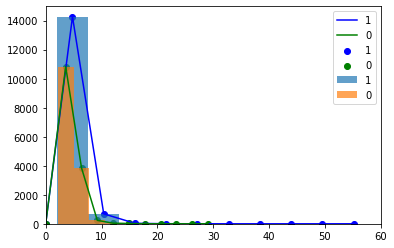

In [ ]:
plt.hist(df.loc[df.sentiment==1, "avg_word_length"], alpha=0.7)
plt.hist(df.loc[df.sentiment==0, "avg_word_length"], alpha=0.7)

y, bin_edge = np.histogram(df.loc[df.sentiment==1, "avg_word_length"])
y = np.append(0, y)
bin_centre = np.append(0, (bin_edge[1: ] + bin_edge[: -1])/2)
plt.plot(bin_centre, y, c="blue")
plt.scatter(bin_centre, y, c="blue")

y, bin_edge = np.histogram(df.loc[df.sentiment==0, "avg_word_length"])
y = np.append(0, y)
bin_centre = np.append(0, (bin_edge[1: ] + bin_edge[: -1])/2)
plt.plot(bin_centre, y, c="green")
plt.scatter(bin_centre, y, c="green")

plt.xlim(0, 60)
plt.legend([1, 0, 1, 0, 1, 0])

df[["sentiment", "avg_word_length"]].groupby("sentiment").mean()

does not seem to be of much significance

## sentiment vs mentions

,mentions
sentiment,
0,0.395533
1,0.584200


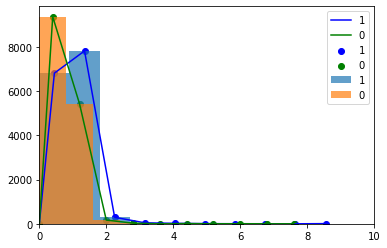

In [ ]:
plt.hist(df.loc[df.sentiment==1, "mentions"], alpha=0.7)
plt.hist(df.loc[df.sentiment==0, "mentions"], alpha=0.7)

y, bin_edge = np.histogram(df.loc[df.sentiment==1, "mentions"])
y = np.append(0, y)
bin_centre = np.append(0, (bin_edge[1: ] + bin_edge[: -1])/2)
plt.plot(bin_centre, y, c="blue")
plt.scatter(bin_centre, y, c="blue")

y, bin_edge = np.histogram(df.loc[df.sentiment==0, "mentions"])
y = np.append(0, y)
bin_centre = np.append(0, (bin_edge[1: ] + bin_edge[: -1])/2)
plt.plot(bin_centre, y, c="green")
plt.scatter(bin_centre, y, c="green")

plt.xlim(0, 10)
plt.legend([1, 0, 1, 0, 1, 0])

df[["sentiment", "mentions"]].groupby("sentiment").mean()

does not seem to be significant

## sentiment vs hashtags

,hashtags
sentiment,
0,0.020467
1,0.031400


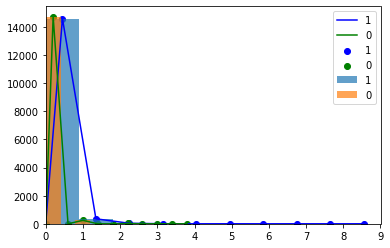

In [ ]:
plt.hist(df.loc[df.sentiment==1, "hashtags"], alpha=0.7)
plt.hist(df.loc[df.sentiment==0, "hashtags"], alpha=0.7)

y, bin_edge = np.histogram(df.loc[df.sentiment==1, "hashtags"])
y = np.append(0, y)
bin_centre = np.append(0, (bin_edge[1: ] + bin_edge[: -1])/2)
plt.plot(bin_centre, y, c="blue")
plt.scatter(bin_centre, y, c="blue")

y, bin_edge = np.histogram(df.loc[df.sentiment==0, "hashtags"])
y = np.append(0, y)
bin_centre = np.append(0, (bin_edge[1: ] + bin_edge[: -1])/2)
plt.plot(bin_centre, y, c="green")
plt.scatter(bin_centre, y, c="green")

plt.xlim(0, 9)
plt.legend([1, 0, 1, 0, 1, 0])

df[["sentiment", "hashtags"]].groupby("sentiment").mean()

does not seem to be significant

## sentiment vs email id

,email_id_count
sentiment,
0,0.000200
1,0.000267


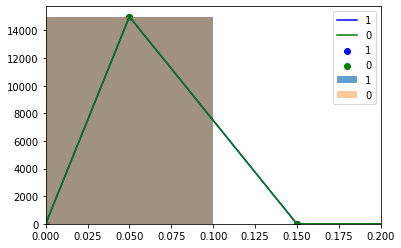

In [ ]:
plt.hist(df.loc[df.sentiment==1, "email_id_count"], alpha=0.7)
plt.hist(df.loc[df.sentiment==0, "email_id_count"], alpha=0.4)

y, bin_edge = np.histogram(df.loc[df.sentiment==1, "email_id_count"])
y = np.append(0, y)
bin_centre = np.append(0, (bin_edge[1: ] + bin_edge[: -1])/2)
plt.plot(bin_centre, y, c="blue")
plt.scatter(bin_centre, y, c="blue")

y, bin_edge = np.histogram(df.loc[df.sentiment==0, "email_id_count"])
y = np.append(0, y)
bin_centre = np.append(0, (bin_edge[1: ] + bin_edge[: -1])/2)
plt.plot(bin_centre, y, c="green")
plt.scatter(bin_centre, y, c="green")

plt.xlim(0, 0.2)
plt.legend([1, 0, 1, 0, 1, 0])

df[["sentiment", "email_id_count"]].groupby("sentiment").mean()

this is not a separating feature

## sentiment vs hi_emotion

(array([1.4685e+04, 1.8500e+02, 7.8000e+01, 2.2000e+01, 1.3000e+01,
        0.0000e+00, 6.0000e+00, 2.0000e+00, 7.0000e+00, 2.0000e+00]),
 array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5, 25. ]),
 <a list of 10 Patch objects>)

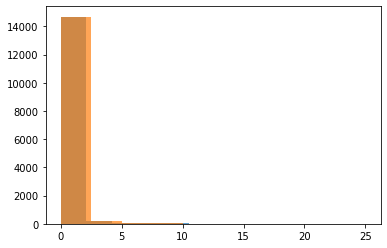

In [ ]:
plt.hist(df.loc[df["sentiment"] == 1, "hi_emotion"], alpha=0.7)
plt.hist(df.loc[df["sentiment"] == 0, "hi_emotion"], alpha=0.7)

## Feature Extraction

N-gram: combination of n words taken together

e.g. he is good
*   **unigram**: he, is, good
*   **bigram**: he is, is good
*   **trigram**: he is good

bag of words: a matrix of n-grams. n-grams in columns, row represents each row in the dataframe. values in each column represent the number of occurences of the n-gram in that column in a line.

instead of words, n-grams (n>1) are used in BoW. if single words (unigrams) are used, the ordering of each word in a line would be lost.

**Term Frequency (TF)**: ratio of the count of an n-gram to the total count of n-grams in a line. Stopwords generally have the highest term frequency, so may produce incorrect results.

**Inverse Document frequency (IDF)**:
idf = log((1+N)/(n+1)) + 1

  n: number of rows (documents) in which the n-gram is present.

  N: total number of rows (documents).
  
---
TF: most frequent words have highest significance

IDF: least frequent words have highest significance

For analysis, a combination of TF and IDF is used.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer as tfidf
tiv = tfidf(ngram_range=(1, 2), min_df=3)

bow = tiv.fit_transform(df["twitts"])
y = df.sentiment.values

Splitting the dataset

In [ ]:
from sklearn.model_selection import train_test_split as tts
xtr, xte, ytr, yte = tts(bow, y, test_size=0.2, random_state=0)

In [ ]:
xtr.shape

(24000, 12100)

#Linear Classifier

##### OLS

##### RidgeCV

In [ ]:
from sklearn.linear_model import RidgeClassifier
clsfr = RidgeClassifier()
clsfr.fit(xtr, ytr)
cls_type = "ridge"

## logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
clsfr = LogisticRegression(random_state=0, solver="saga", penalty="l1")
clsfr.fit(xtr, ytr)
cls_type = "log"

# linearSVM

In [ ]:
from sklearn.svm import SVC
clsfr = SVC(kernel="linear", random_state=0)
clsfr.fit(xtr, ytr)
cls_type = "linear svm"

#  Validation

Predicting the results

In [ ]:
ypred = clsfr.predict(xte)

Getting the confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
print(cls_type)
print(confusion_matrix(yte, ypred))
print(f"accuracy: {accuracy_score(yte, ypred)}")
print(f"precision: {precision_score(yte, ypred)}")
print(f"recall: {recall_score(yte, ypred)}")
print(f"f-score: {f1_score(yte, ypred)}")

log
[[2110  944]
 [ 632 2314]]
accuracy: 0.7373333333333333
precision: 0.7102516881522406
recall: 0.7854718262050238
f-score: 0.7459703417150225


#  Testing

In [ ]:
test = pd.read_csv("/content/drive/MyDrive/twitter4000.csv")

test["twitts"] = test["twitts"].str.replace("RT ", "")
test["twitts"] = test.twitts.map(lambda x: re.sub(r"(\d*)([,:hmys])(\d+)", r'\1\3', x))  # for comma separated numbers and time
test["twitts"] = test.twitts.map(lambda x: re.sub(r"(\d*)[.](\d+)", r'\1_\2',x))  # for decimal digits
test["twitts"] = test.twitts.map(lambda x:re.sub(r'(\d) ([hmys]) (\d+)', r'\1\3 \2', x))
test["twitts"] = test.twitts.map(lambda x: re.sub(r'[^\w]', " ", x))
test["twitts"] = test.twitts.map(lambda x: BeautifulSoup(x, "lxml").get_text().strip())
test["twitts"] = test.twitts.map(lambda x: unicodedata.normalize("NFKC", x.lstrip()).encode("ascii", "ignore").decode("utf-8"))
test["twitts"] = test.twitts.map(lambda x: " ".join([word for word in str(x).split() if word not in nlp.Defaults.stop_words]))
test["twitts"] = test.twitts.map(lambda x: " ".join([token.text if token.lemma_ == "-PRON-" or token.lemma_ == "be" else token.lemma_ for token in nlp(x)]))
test["twitts"] = test.twitts.map(lambda x: re.sub(r'(\d)([a-zA-z])', r'\1 \2', x))
test["twitts"] = test.twitts.map(lambda x: re.sub(r'([a-zA-Z])(\d)', r'\1 \2', x))
test["twitts"] = test.twitts.map(lambda x: re.sub(r"([a-zA-Z0-9])\1{2,}", r"\1", x))

KeyboardInterrupt: ignored

In [ ]:
x = tiv.transform(test.twitts)
y = test.sentiment

Predicting the results

In [ ]:
ypred = clsfr.predict(x)

Getting the confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
print(cls_type)
print(confusion_matrix(y, ypred))
print(f"accuracy: {accuracy_score(y, ypred)}")
print(f"precision: {precision_score(y, ypred)}")
print(f"recall: {recall_score(y, ypred)}")
print(f"f-score: {f1_score(y, ypred)}")

linear svm
[[1394  606]
 [ 463 1537]]
accuracy: 0.73275
precision: 0.7172188520765282
recall: 0.7685
f-score: 0.741974414675356


In [ ]:
statement = "cold coffee is hot"
statement = " ".join([word for word in statement.split() if word not in nlp.Defaults.stop_words])
print(statement)
clsfr.predict(tiv.transform([statement]))

cold coffee hot


array([0])